(2961, 2961)


C:\Users\G-shop\anaconda3\Lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:395: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)


(2961, 360)
(360, 360)
(360, 360)
Execution time: 0.7872109413146973
Space dimension: 360


C:\Users\G-shop\anaconda3\Lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:214: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


H∞ norm: 5.46130596412344


FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/G-shop/Desktop/RAPPORT-Master/hinf_norm_plot.png'

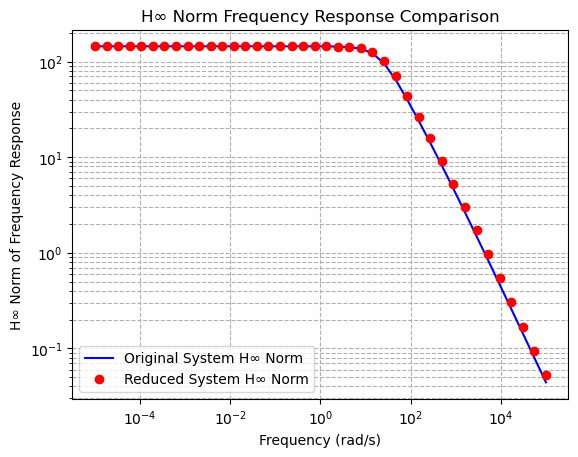

In [1]:
import numpy as np
from scipy.linalg import solve
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import mmread 
from scipy.sparse.linalg import spsolve
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds, LinearOperator, aslinearoperator
from scipy.sparse import eye, linalg as splinalg
import scipy.sparse as sps
from numerical_test1 import fdm_matrix1
from scipy.linalg import svdvals
from scipy.linalg import lu_factor, lu_solve, qr
from scipy.signal import lti
#from requirements import eteld
from build_matrix_A import build_matrix_A
import time
import scipy.io
from scipy.sparse.linalg import splu
from numpy.linalg import norm

def eteld(i, p, m):
    ei = np.zeros((2 * (m + 1) , 1))  
    ei[i - 1, 0] = 1  
    Ip = np.eye(p)
    return np.kron(ei, Ip) 

def extended_block_arnoldi(A, V0, m):
    n, p = V0.shape
    V = np.zeros((n, 2 * (m + 1) * p))  
    H = np.zeros((2 * (m + 1) * p, 2 * p * m))  
    T = np.zeros((2 * (m + 1) * p, 2 * p * m))  

    lu = splu(A)  
    V0_new = np.hstack((V0, lu.solve((V0))))
    Q, Z = qr(V0_new, mode='economic')  
    V[:, :2 * p] = Q  

    for j in range(m):
        Vj1 = V[:, 2 * j * p : 2 * j * p + p]  
        Vj2 = V[:, 2 * j * p + p : 2 * (j + 1) * p]  
        AVj1 = A @ Vj1  
        A_invVj2 = lu.solve((Vj2))  
        Wj = np.hstack((AVj1, A_invVj2))

        
        for i in range(j + 1):
            Hij = V[:, 2 * i * p : 2 * (i + 1) * p].T @ Wj
            H[2 * i * p : 2 * (i + 1) * p, 2 * j * p : 2 * (j + 1) * p] = Hij
            Wj -= V[:, 2 * i * p : 2 * (i + 1) * p] @ Hij

        Vj1, Hj1j = qr(Wj, mode='economic')
        V[:, 2 * (j + 1) * p : 2 * (j + 2) * p] = Vj1
        H[2 * (j + 1) * p : 2 * (j + 2) * p, 2 * j * p : 2 * (j + 1) * p] = Hj1j
        #T[: , 2*j*p:2*j*p + p] = H[:, 2*j*p:2*j*p + p]
        #T[:, p:2*p] = (eteld(1, p, m) @ Z[:p,:p] - T[:,:p] @ Z[:p,p:2*p]) @ np.linalg.inv(Z[p:2*p,p:2*p])
        #if j < m - 1:
         #   temp = eteld(2 * j + 2, p, m) - T[:, :(2 * j + 3) * p] @ H[:(2 * j + 3) * p, (2 * j + 1) * p:(2 * j + 2) * p]
         #   T[: , (2 * j + 1) * p : (2 * j + 2) * p] = temp @ np.linalg.inv(Hj1j[p:2*p,p:2*p])
    #print(T.shape)
   
    return V[:,:2*m*p], H, #T

#n0 = 100
p = 6
Nx = 47
Ny = 63
A0 = build_matrix_A(Nx, Ny)
#A0 = fdm_matrix1(n0)
A = csr_matrix(A0)
print(A.shape)
n, n = A.shape
B = np.random.uniform(0, 1, (n, p))
C = np.random.uniform(0, 1, (p, n))

m = 30  # Number of steps for Arnoldi

start_time = time.time()
V, H = extended_block_arnoldi(A, B, m)
execution_time = time.time() - start_time
print(V.shape)
Am = V.T @ A @ V
print(Am.shape)#T[:2 * m * p, :]
Bm = V.T @ B  
Cm = C @ V

I=np.eye(2*m*p)
print(I.shape)
# Measure space dimension
space_dimension = Am.shape[0]

print("Execution time:", execution_time)
print("Space dimension:", space_dimension)

frequencies = np.logspace(-5, 5, num=40)
response_original, response_reduced, error_responses_EBA = [], [], []

for omega in frequencies:
    s = 1j * omega
    sI_minus_A = s * eye(A.shape[0], format='csr') - A
    H_full = C @ spsolve(sI_minus_A, B)
    #u, s, vt = svds(H_full, k=1, which='LM')
    #response_original.append(s[0])
    response_original.append(norm(H_full, ord=2))
    
    sI_minus_Am = s * np.eye(2*m*p) - Am
    H_reduced = Cm @ spsolve(sI_minus_Am, Bm)
    response_reduced.append(svds(H_reduced, k=1, which='LM', return_singular_vectors=False)[0])
    
    # Calculate the difference in the largest singular value (H∞ norm)
    error_responses_EBA.append(np.abs(response_original[-1] - response_reduced[-1]))

np.save('error_responses_EBA.npy', error_responses_EBA)
H_infinity_error = np.max(error_responses_EBA)

print("H∞ norm:", H_infinity_error)
# Now we have the H∞ norms and errors, we can plot them
figsize = (10, 8)

plt.subplot(1, 1, 1)
plt.loglog(frequencies, response_original, 'b-', label='Original System H∞ Norm')
plt.loglog(frequencies, response_reduced, 'ro', label='Reduced System H∞ Norm')
plt.xlabel('Frequency (rad/s)')
plt.ylabel('H∞ Norm of Frequency Response')
plt.title('H∞ Norm Frequency Response Comparison')
plt.legend()
plt.grid(True, which='both', ls='--')
plt.savefig('C:/Users/G-shop/Desktop/RAPPORT-Master/hinf_norm_plot.png') 
plt.show()
plt.clf()

plt.subplot(1, 1, 1)
plt.loglog(frequencies, error_responses_EBA, 'r-', label='Error between Systems')
plt.xlabel('Frequency (rad/s)')
plt.ylabel('Error (H∞ Norm Difference)')
plt.title('Error in H∞ Norm between Original and Reduced Systems')
plt.legend()
plt.grid(True, which='both', ls='--')
plt.tight_layout()
plt.savefig('C:/Users/G-shop/Desktop/RAPPORT-Master/error_plot.png')
plt.show()